In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from copy import deepcopy
from itertools import combinations_with_replacement
from networkx.algorithms import bipartite
from scipy.integrate import solve_ivp
from scripts.emn_model import (
    get_clean_dataset, generate_bipartite_network, diffusion_dynamics, tree_project_network
)

#### Visualization

In [12]:
TEX_PLOTS = True

# Plotting config
if TEX_PLOTS:
    plt.rc("text", usetex=True)
    plt.rc("font", family="serif")
    plt.rc("text.latex", preamble=r"""
         \usepackage{times}
         \usepackage{mathptmx}
         \usepackage{siunitx}""")
else:
    plt.rc("text", usetex=False)

mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.labelsize"] = mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.2
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["lines.linewidth"] = 1

cmap = mpl.cm.get_cmap("Dark2")
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=cmap.colors)

np.random.seed(1231)

# Results Barabasi Scale-Free network

### Initialization of the network.

In [18]:
from scripts.forest_generator import generate_barabasi_forest

G= generate_barabasi_forest(54, 9, 302)

graph has average degree of  15.0
graph has average shortest path length of  1.7330538085255067


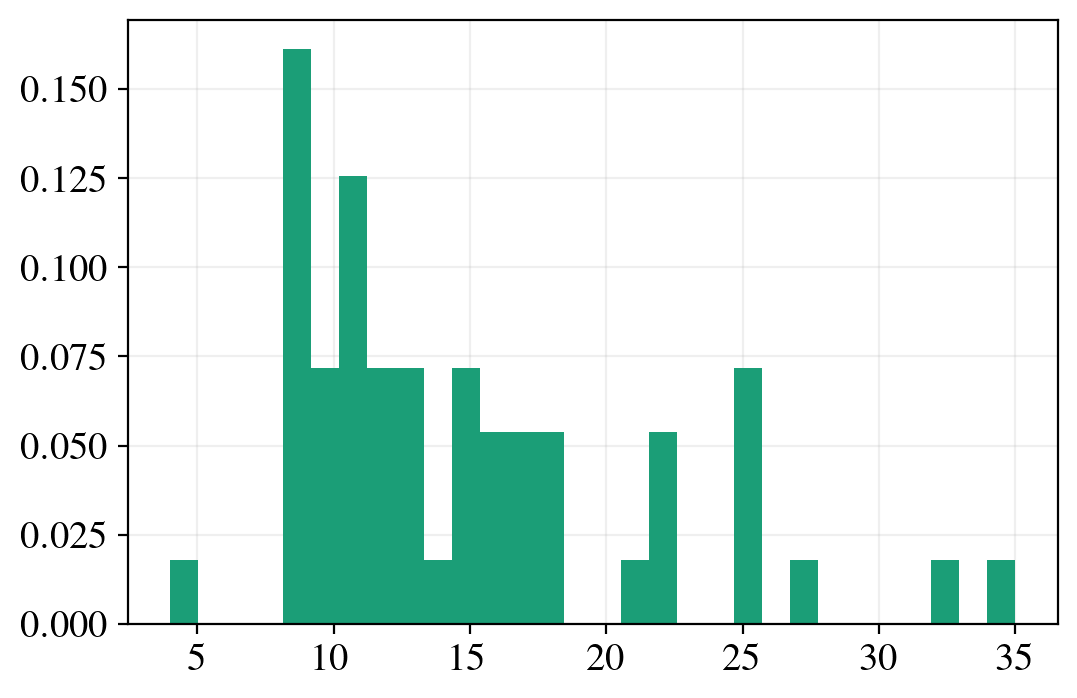

In [19]:
degrees = [v for k,v in G.degree()]
_ = plt.hist(degrees, bins=30, density=True)
print(f"graph has average degree of ", np.mean(degrees))
print(f"graph has average shortest path length of ", nx.average_shortest_path_length(G))


In [20]:
N = len(G.nodes)

plant_carbon_0 = np.array(list(nx.get_node_attributes(G, "carbon_value").values()))
root_carbon_0 = 0.1 * plant_carbon_0
plant_diameter_0 = np.array(list(nx.get_node_attributes(G, "diameter").values()))

t_range = (0, 16_000)
D_C = 5.0e-4 # carbon diffusion coeff
uptake_ps = (0.55, 0.0, 55.0)
f = 5.0e-4 # sensitive w.r.t plant carbon deposition
k = 0.6
g = 0.004
c = 0.82
rho = 0.01

sol = solve_ivp(diffusion_dynamics, t_range, np.concatenate([root_carbon_0, plant_carbon_0, plant_diameter_0]),
                args=(G, D_C, N, uptake_ps, f, k, c, g, rho), dense_output=True, method="BDF")

time_steps = 300
t = np.linspace(t_range[0], t_range[1], time_steps)
z = sol.sol(t)

#Rename the quantities of interest
roots_carbon, plant_carbon, plant_diameter = z[:N, :], z[N:2*N, :], z[2*N:3*N, :] 

In [21]:
nodes_by_cohort = {"Sapling": [], "Maturing": [], "Established": []}
node_list = list(G.nodes)

for node in G.nodes:
    nodes_by_cohort[G.nodes[node]["cohort"]].append(node)

### Group information

In [22]:
ONE_YEAR = 16_000 # time steps equal to one year

t_in_days = (t/t_range[1])*(365./(ONE_YEAR/t_range[1]))

Cohort Sapling grew on average 2.04 cm
Cohort Sapling grew on average 670.59% +- 2318.87

 #### Sapling statistics #######
Sapling competition between samplings (std growth percentage) 2318.87%
23 out of the 36 Saplings were successful. That is 63.89%


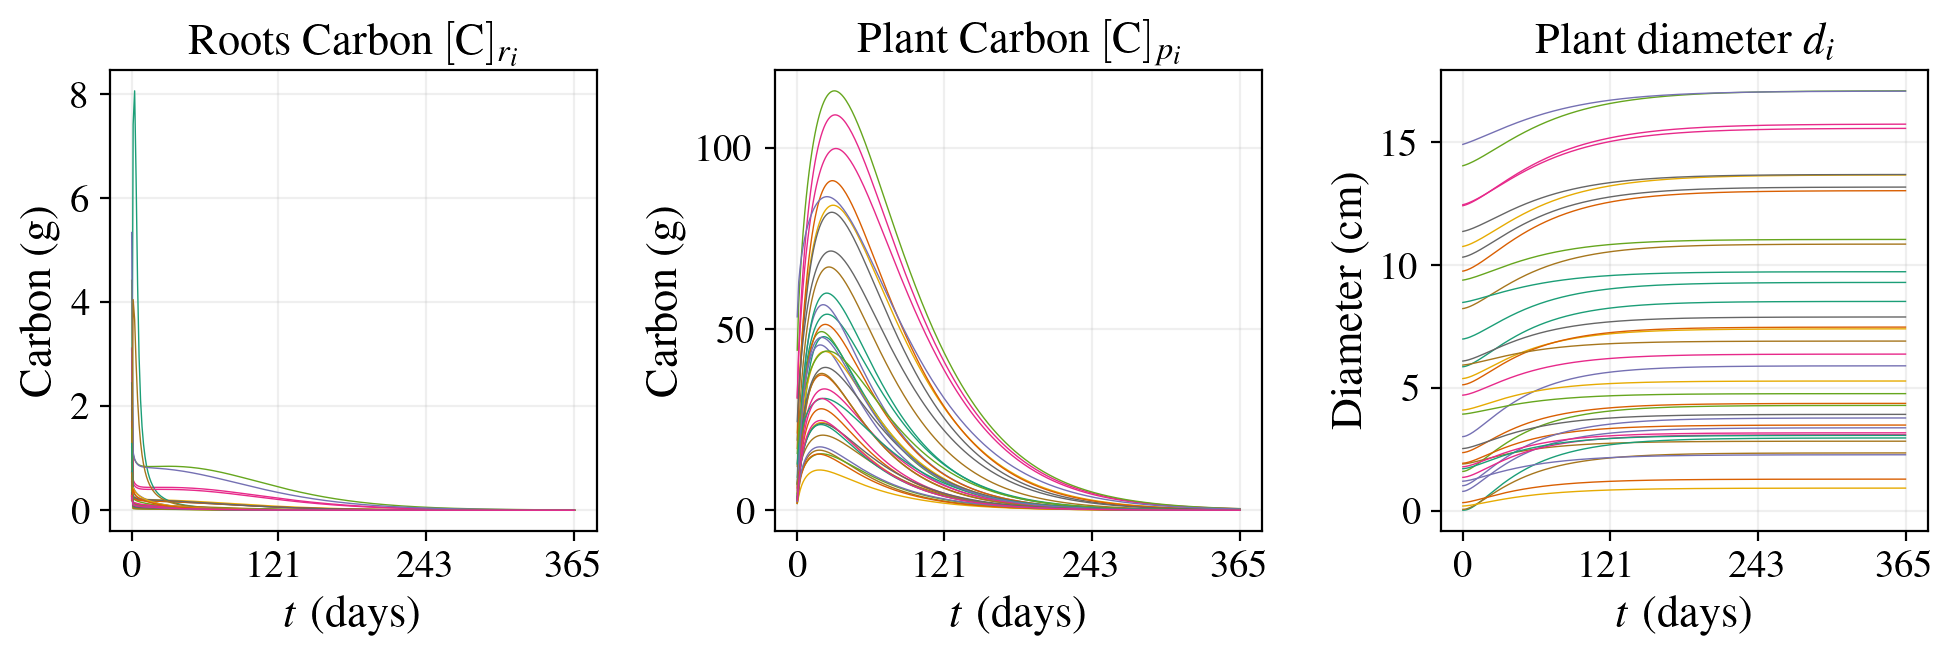

Cohort Maturing grew on average 1.39 cm
Cohort Maturing grew on average 106.69% +- 4.06


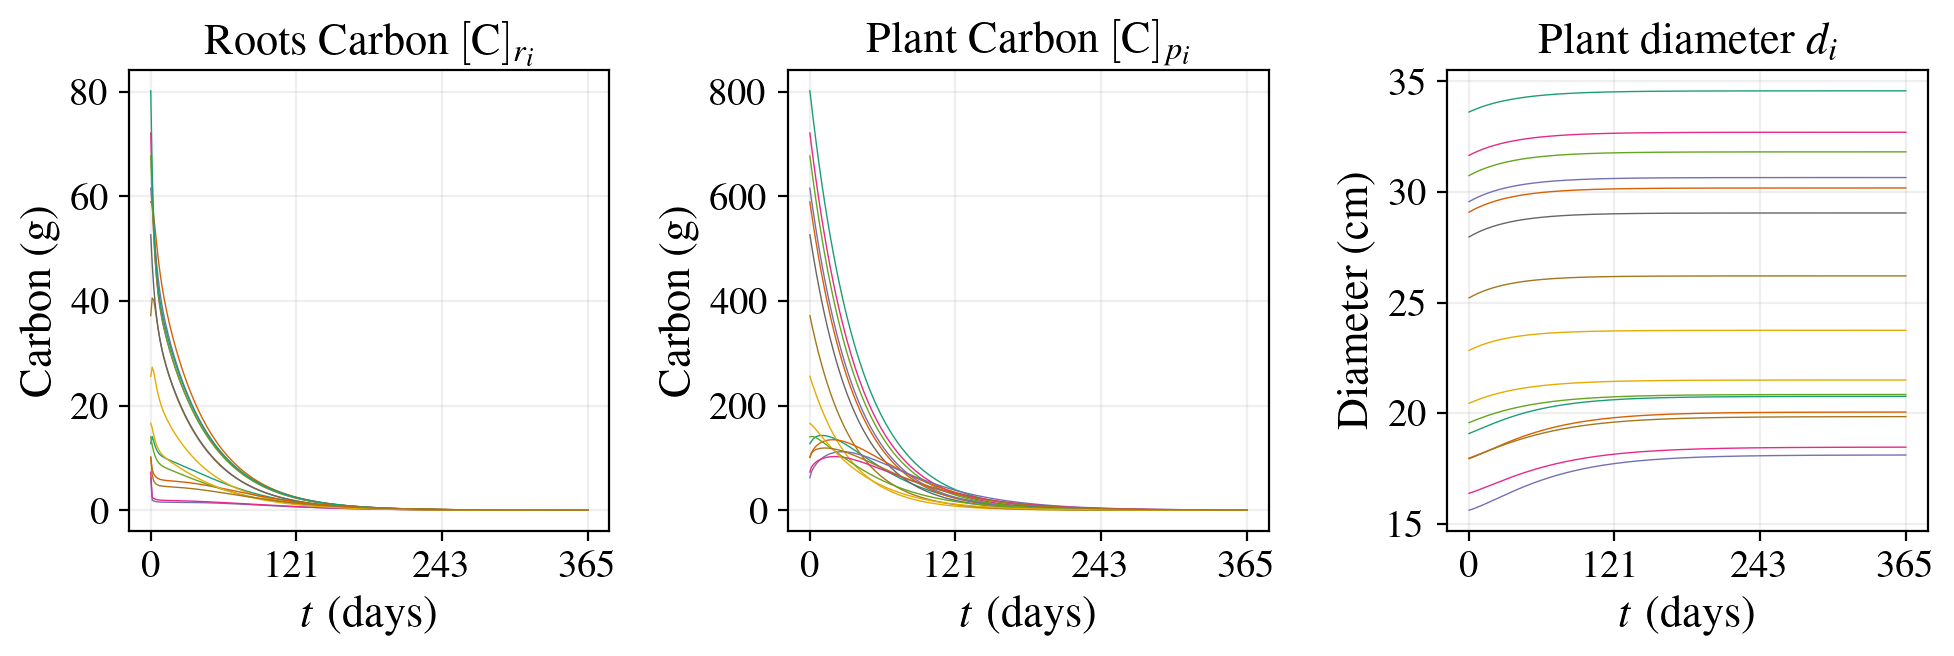

Cohort Established grew on average 0.25 cm
Cohort Established grew on average 100.58% +- 0.61


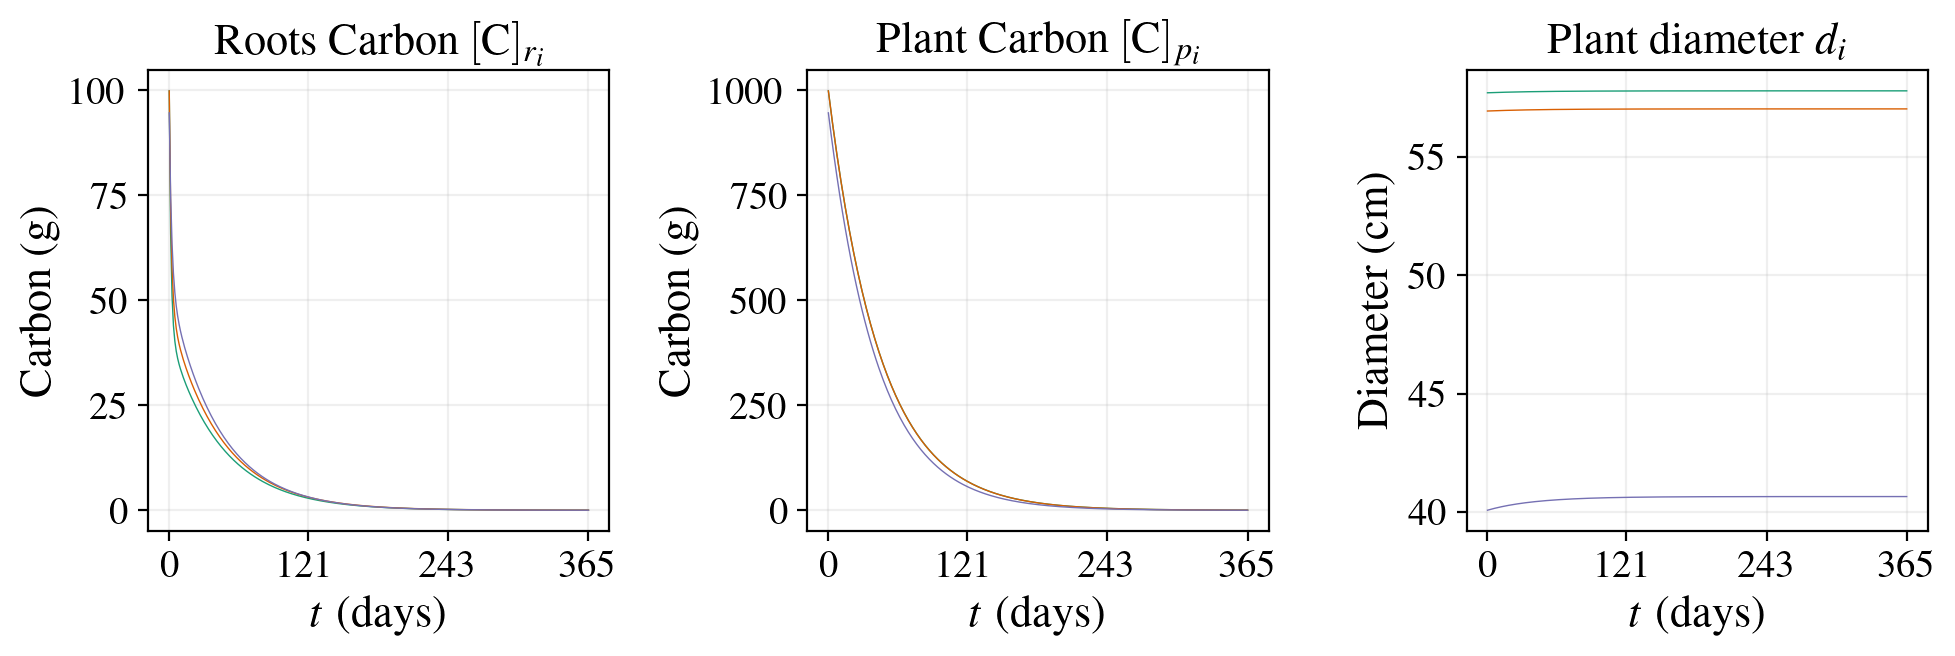

In [24]:
for cohort, nodes in nodes_by_cohort.items():
    
    node_idxs = [node_list.index(node) for node in nodes]
    
    #Calculate Average growth
    growth = plant_diameter[node_idxs, -1] - plant_diameter[node_idxs, 0]
    avg_growth = np.mean(growth)
    
    #Calculate growth in percantages
    percentages = plant_diameter[node_idxs, -1]/plant_diameter[node_idxs, 0]*100
    percentage_mean = np.mean(percentages)
    percentage_stdev = np.std(percentages)


    print(f"Cohort {str(cohort)} grew on average {avg_growth:.2f} cm")
    print(f"Cohort {str(cohort)} grew on average {percentage_mean:.2f}% +- {percentage_stdev:.2f}")
    
    if cohort == "Sapling": 
        success_threshold = np.max(growth)/2
        n_successes =  np.sum([growth >= success_threshold])     #np.sum([percentages >= 200])
                
        print("\n #### Sapling statistics #######")
        print(f"Sapling competition between samplings (std growth percentage) {percentage_stdev:.2f}%")
        print(f"{n_successes} out of the {len(percentages)} Saplings were successful. That is {n_successes/len(percentages)*100:.2f}%")

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi=200)

    axes[0].set_title(r"Roots Carbon $[\text{C}]_{r_i}$")
    axes[0].plot(t_in_days, roots_carbon[node_idxs, :].T, linewidth=0.5)
    axes[0].set_ylabel("Carbon (g)")

    axes[1].set_title(r"Plant Carbon $[\text{C}]_{p_i}$")
    axes[1].plot(t_in_days, plant_carbon[node_idxs, :].T, linewidth=0.5)
    axes[1].set_ylabel("Carbon (g)")

    axes[2].set_title(r"Plant diameter $d_i$")
    axes[2].plot(t_in_days, plant_diameter[node_idxs, :].T, linewidth=0.5)
    axes[2].set_ylabel("Diameter (cm)")
    
    for ax in axes:
        ax.set_xlabel("$t$ (days)")
        ax.set_xticks(np.linspace(0, t_in_days[-1], 4, dtype=int))

    plt.tight_layout()
    plt.show()

### Nutrient flows

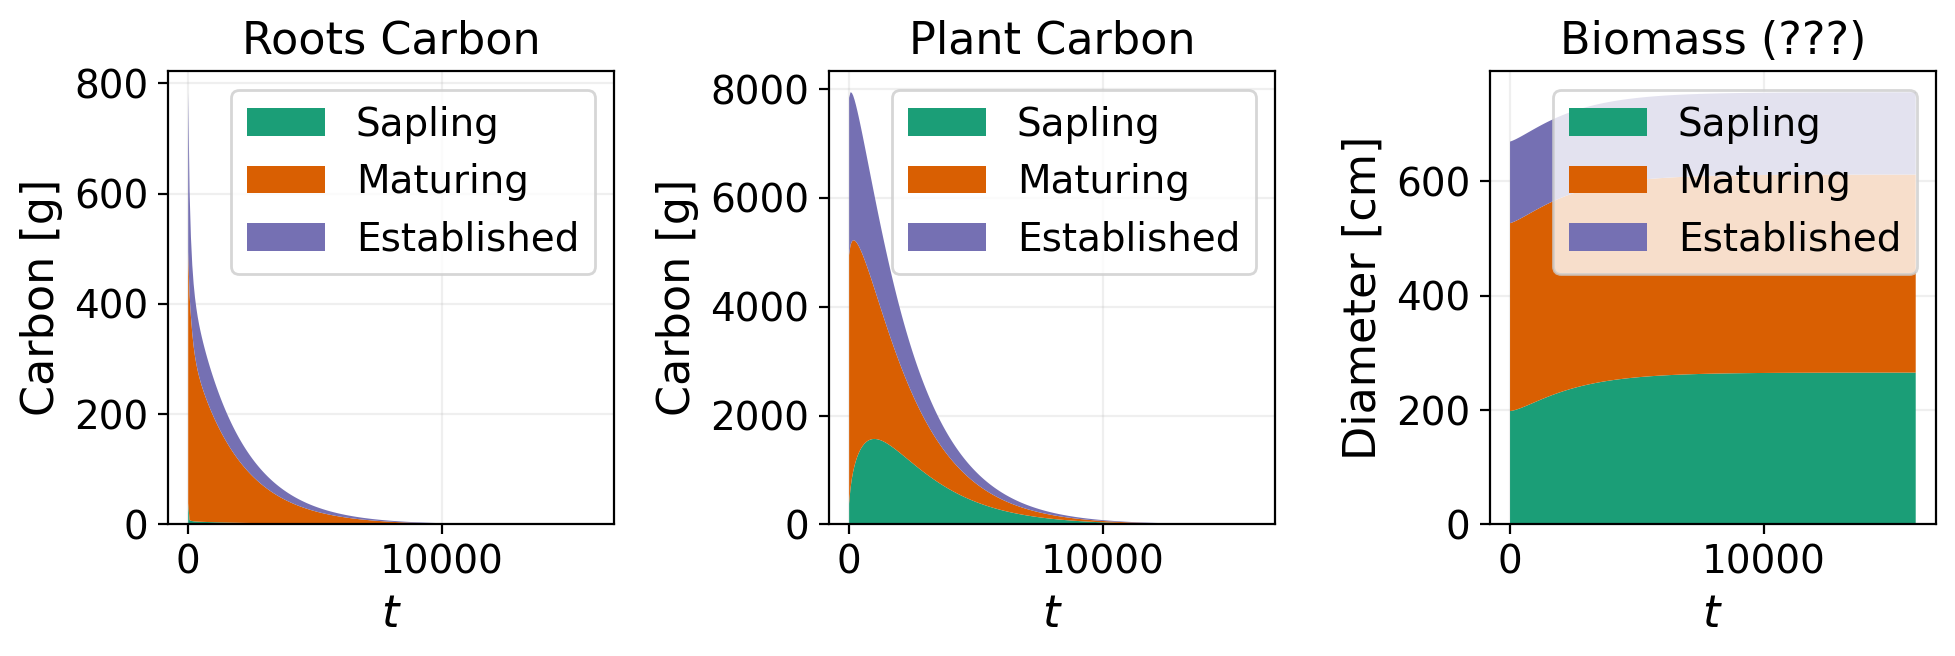

In [10]:
roots_carbon_per_cohort = {}
plant_carbon_per_cohort = {}
plant_diameter_per_cohort = {}


for cohort, nodes in nodes_by_cohort.items():
    
    node_idxs = [node_list.index(node) for node in nodes]
    
    #not sure if total diameter makes sense, but currently included to show growth. 
    total_diameter = np.sum(plant_diameter[node_idxs, :], axis = 0)
    total_plant_carbon = np.sum(plant_carbon[node_idxs, :], axis = 0)
    totaL_root_carbon  = np.sum(roots_carbon[node_idxs, :], axis = 0)
    
    roots_carbon_per_cohort[cohort] = totaL_root_carbon
    plant_carbon_per_cohort[cohort] = total_plant_carbon
    plant_diameter_per_cohort[cohort] = total_diameter
    

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi=200)

axes[0].set_title("Roots Carbon")
axes[0].stackplot(t, np.array(list(roots_carbon_per_cohort.values())))
axes[0].legend(labels = np.array(list(roots_carbon_per_cohort.keys())))
axes[0].set_ylabel("Carbon [g]")
axes[0].set_xlabel("$t$")


axes[1].set_title("Plant Carbon")
axes[1].stackplot(t, np.array(list(plant_carbon_per_cohort.values())))
axes[1].legend(labels = np.array(list(plant_carbon_per_cohort.keys())))
axes[1].set_ylabel("Carbon [g]")
axes[1].set_xlabel("$t$")


axes[2].set_title("Biomass (???)")
axes[2].stackplot(t, np.array(list(plant_diameter_per_cohort.values())))
axes[2].legend(labels = np.array(list(plant_diameter_per_cohort.keys())))
axes[2].set_ylabel("Diameter [cm]")
axes[2].set_xlabel("$t$")

 
plt.tight_layout()
plt.show()

Succesful nodes [ 1  3  4  5  6  8 22 23 24 25 26 27 28 29 32 33 34 35 36 40 41 44 45]
Unsuccesful nodes [ 9 37 39 42 43 46 47 48 49 50 51 52 53]


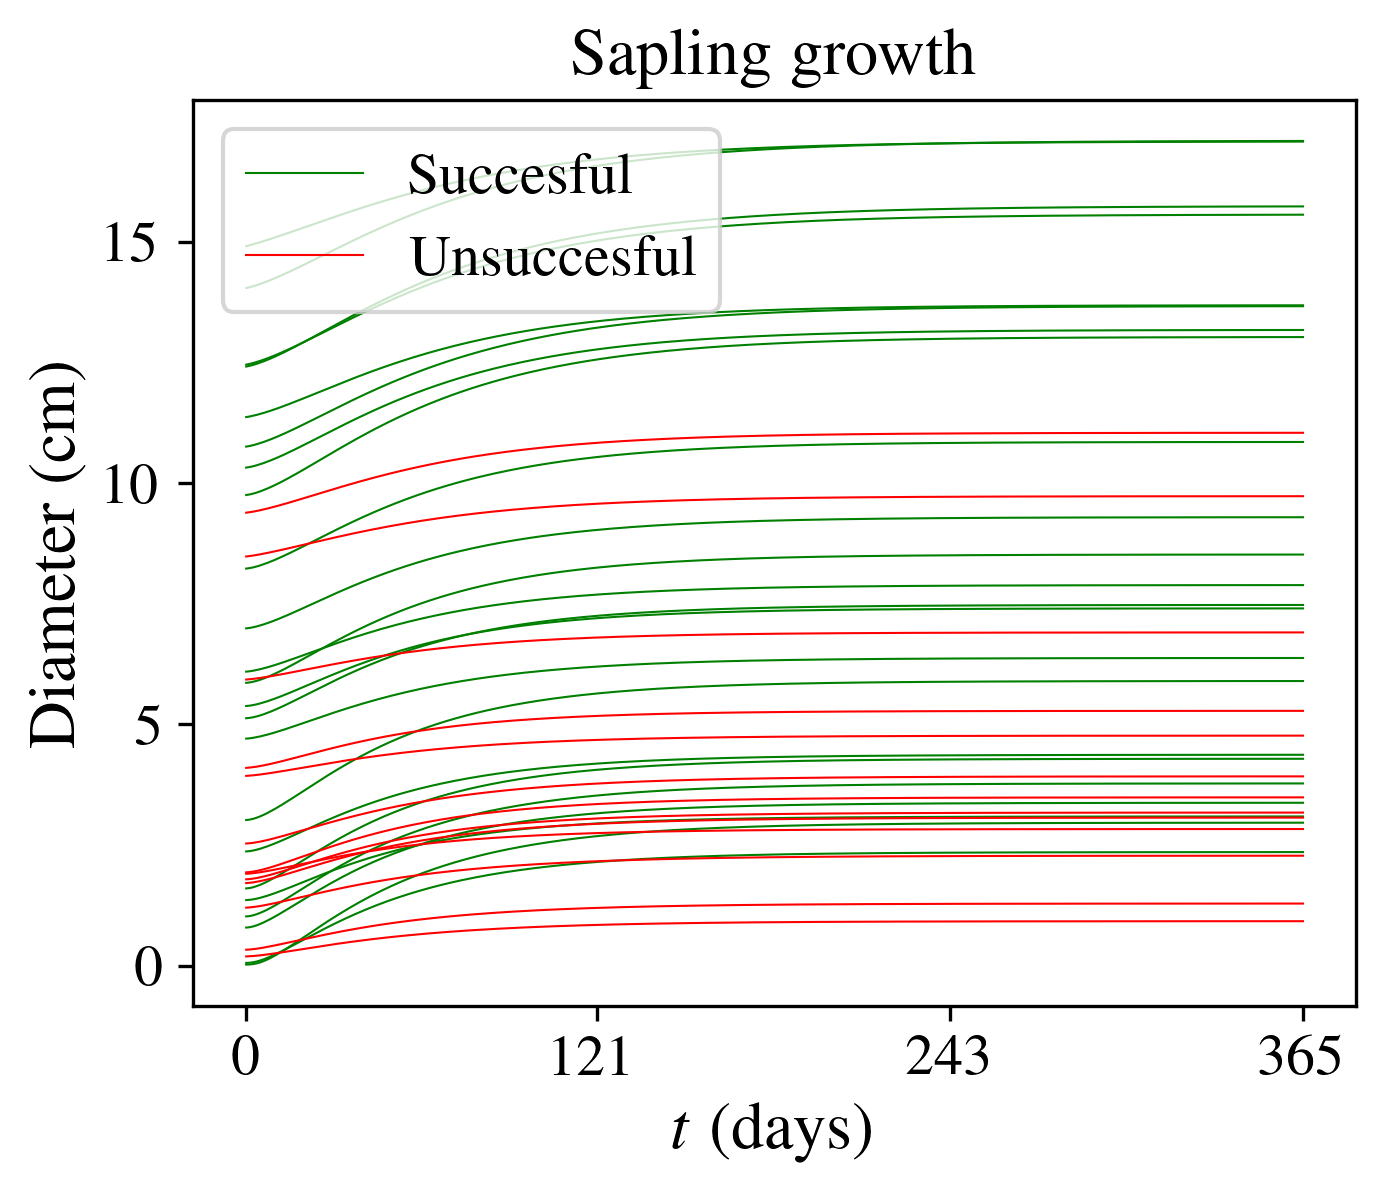

In [26]:
sapling_nodes = nodes_by_cohort["Sapling"]
node_idxs = np.array([node_list.index(node) for node in sapling_nodes])
growth = plant_diameter[node_idxs, -1] - plant_diameter[node_idxs, 0]

success_threshold = np.max(growth)/2

successful_nodes = node_idxs[growth >= success_threshold]
unsuccessful_nodes = node_idxs[growth < success_threshold]

print(f"Succesful nodes {successful_nodes}")
print(f"Unsuccesful nodes {unsuccessful_nodes}")

labels1 = [None]*(len(successful_nodes)-1)
labels1.append("Succesful")

labels2 = [None]*(len(unsuccessful_nodes)-1)
labels2.append("Unsuccesful")

plt.figure(figsize=(5, 4), dpi=300)

plt.plot(t_in_days, plant_diameter[successful_nodes, :].T, linewidth=0.5, color = "green", label = labels1)
plt.plot(t_in_days, plant_diameter[unsuccessful_nodes, :].T, linewidth=0.5, color = "red", label = labels2)

plt.title("Sapling growth")
plt.xlabel("$t$ (days)")
plt.ylabel("Diameter (cm)")
plt.xticks(np.linspace(0, t_in_days[-1], 4, dtype=int))
plt.legend()
plt.grid(False)

if TEX_PLOTS:
    plt.savefig(f"figures/forest_network_sapling_survival_barabasi.png", bbox_inches="tight")

plt.show()